In [10]:
import glob
import pandas as pd

# get list of all protein IDs
protein_list = []
for file in glob.glob('Data/*.csv'):
    protein_list.append(file[5:9])

# generate a list of all dataframes
dfs_list = []

for protein in protein_list:
  df = pd.read_csv("Data/" + protein + "_seq_lab.csv")
  df["protein_id"] = protein
  dfs_list.append(df)
# merge all dataframes to one dataframe
data_all = pd.concat(dfs_list)

In [11]:
import re
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

class Preprocessing:

    def __init__(self, data, num_words, seq_len=1024):
        self.data = data
        self.seq_len = seq_len
        self.num_words = num_words        
        self.vocabulary = None
        self.x_tokenized = None
        self.x_padded = None
        self.x_raw = None
        self.y = None

        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        # Reads the raw csv file and split into
        # sentences (x) and target (y)

        df = self.data

        self.x_raw = df['seqs'].values
        self.y = df['labels'].values

    def text_tokenization(self):
        # Tokenizes each sentence by implementing the nltk tool
        self.x_raw = [char_tokenize(x) for x in self.x_raw]

    def build_vocabulary(self):
        # Builds the vocabulary and keeps the "x" most frequent words
        self.vocabulary = dict()
        fdist = nltk.FreqDist()

        for sentence in self.x_raw:
            for word in sentence:
                fdist[word] += 1

        common_words = fdist.most_common(self.num_words)

        for idx, word in enumerate(common_words):
            self.vocabulary[word[0]] = (idx+1)
  
    def word_to_idx(self):
        # By using the dictionary (vocabulary), it is transformed
        # each token into its index based representation

        self.x_tokenized = list()

        for sentence in self.x_raw:
            temp_sentence = list()
            for word in sentence:
                if word in self.vocabulary.keys():
                    temp_sentence.append(self.vocabulary[word])
            self.x_tokenized.append(temp_sentence)
	      
    def padding_sentences(self):
        # Each sentence which does not fulfill the required len
        # it's padded with the index 0

        pad_idx = 0
        self.x_padded = []
        
        for sentence in self.x_tokenized:
            if len(sentence) > self.seq_len:
                sentence = sentence[:self.seq_len]
            else: pass
            while len(sentence) < self.seq_len:
                sentence.insert(len(sentence), pad_idx)
            self.x_padded.append(sentence)
        # self.x_padded = np.array(self.x_padded)

In [12]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextClassifier(nn.ModuleList):

	def __init__(self, params):
		super(TextClassifier, self).__init__()

		# Parameters regarding text preprocessing
		self.seq_len = params.seq_len
		self.num_words = params.num_words
		self.embedding_size = params.embedding_size
		self.dropout_rate = params.dropout_rate
		
		# Dropout definition
		self.dropout = nn.Dropout(self.dropout_rate)
		
		# CNN parameters definition
		# Kernel sizes
		self.kernel_1 = 2
		self.kernel_2 = 3
		self.kernel_3 = 4
		self.kernel_4 = 5
		
		# Output size for each convolution
		self.out_size = params.out_size
		# Number of strides for each convolution
		self.stride = params.stride
		
		# Embedding layer definition
		self.embedding = nn.Embedding(self.num_words + 1, self.embedding_size, padding_idx=0)
		
		# Convolution layers definition
		self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
		self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
		self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)
		self.conv_4 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_4, self.stride)
		
		# Max pooling layers definition
		self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
		self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
		self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)
		self.pool_4 = nn.MaxPool1d(self.kernel_4, self.stride)
		
		# Fully connected layer definition
		self.fc = nn.Linear(self.in_features_fc(), 1)

		
	def in_features_fc(self):
		'''Calculates the number of output features after Convolution + Max pooling
			
		Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
		Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
		
		source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
		'''
		# Calcualte size of convolved/pooled features for convolution_1/max_pooling_1 features
		out_conv_1 = ((self.embedding_size - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
		out_conv_1 = math.floor(out_conv_1)
		out_pool_1 = ((out_conv_1 - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
		out_pool_1 = math.floor(out_pool_1)
		
		# Calcualte size of convolved/pooled features for convolution_2/max_pooling_2 features
		out_conv_2 = ((self.embedding_size - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
		out_conv_2 = math.floor(out_conv_2)
		out_pool_2 = ((out_conv_2 - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
		out_pool_2 = math.floor(out_pool_2)
		
		# Calcualte size of convolved/pooled features for convolution_3/max_pooling_3 features
		out_conv_3 = ((self.embedding_size - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
		out_conv_3 = math.floor(out_conv_3)
		out_pool_3 = ((out_conv_3 - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
		out_pool_3 = math.floor(out_pool_3)
		
		# Calcualte size of convolved/pooled features for convolution_4/max_pooling_4 features
		out_conv_4 = ((self.embedding_size - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
		out_conv_4 = math.floor(out_conv_4)
		out_pool_4 = ((out_conv_4 - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
		out_pool_4 = math.floor(out_pool_4)
		
		# Returns "flattened" vector (input for fully connected layer)
		return (out_pool_1 + out_pool_2 + out_pool_3 + out_pool_4) * self.out_size
		
		
		
	def forward(self, x):

		# Sequence of tokes is filterd through an embedding layer
		x = self.embedding(x)
		
		# Convolution layer 1 is applied
		x1 = self.conv_1(x)
		x1 = torch.relu(x1)
		x1 = self.pool_1(x1)
		
		# Convolution layer 2 is applied
		x2 = self.conv_2(x)
		x2 = torch.relu((x2))
		x2 = self.pool_2(x2)
	
		# Convolution layer 3 is applied
		x3 = self.conv_3(x)
		x3 = torch.relu(x3)
		x3 = self.pool_3(x3)
		
		# Convolution layer 4 is applied
		x4 = self.conv_4(x)
		x4 = torch.relu(x4)
		x4 = self.pool_4(x4)
		
		# The output of each convolutional layer is concatenated into a unique vector
		union = torch.cat((x1, x2, x3, x4), 2)
		union = union.reshape(union.size(0), -1)

		# The "flattened" vector is passed through a fully connected layer
		out = self.fc(union)
		# Dropout is applied		
		out = self.dropout(out)
		# Activation function is applied
		out = torch.sigmoid(out)
		
		return out.squeeze()

In [13]:
from torch.utils.data import DataLoader, Dataset

class DatasetMaper(Dataset):

   def __init__(self, x, y):
      self.x = x
      self.y = y
      
   def __len__(self):
      return len(self.x)
      
   def __getitem__(self, idx):
      return self.x[idx], self.y[idx]

In [14]:
def prep_data(train_prots):
    
    train_bool = [ID in set(train_prots) for ID in data_all.protein_id]
    test_bool = [ID not in set(train_prots) for ID in data_all.protein_id]

    train_x, train_y = X[train_bool], y[train_bool]
    test_x, test_y = X[test_bool], y[test_bool]

    data = {}
    data["x_train"] = train_x
    data["y_train"] = train_y
    data["x_test"] = test_x
    data["y_test"] = test_y
    
    return data

In [15]:
from torch import optim
from sklearn.metrics import roc_auc_score

def evaluate(model, loader_test):

    # Set the model in evaluation mode
    model.eval()
    predictions = []

    # Starst evaluation phase
    with torch.no_grad():
        for x_batch, y_batch in loader_test:
            y_pred = model(x_batch)
            predictions += list(y_pred.cpu().detach().numpy())
    return predictions


def calculate_accuray(grand_truth, predictions):
    # Metrics calculation
    true_positives = 0
    true_negatives = 0
    for true, pred in zip(grand_truth, predictions):
        if (pred >= 0.5) and (true == 1):
            true_positives += 1
        elif (pred < 0.5) and (true == 0):
            true_negatives += 1
        else:
            pass
    # Return accuracy
    return (true_positives+true_negatives) / len(grand_truth)

        
def train_model(model, data, params):


    #Initialize dataset maper

    # Initialize loaders
    train_data = DatasetMaper(data['x_train'], data['y_train'])
    test_data = DatasetMaper(data['x_test'], data['y_test'])    
    
    loader_train = DataLoader(train_data, batch_size=params.batch_size)
    loader_test = DataLoader(test_data, batch_size=params.batch_size)

    # Define optimizer
    optimizer = optim.RMSprop(model.parameters(), lr=params.learning_rate)
   
   # Starts training phase
    for epoch in range(params.epochs):
      # Set model in training model
        model.train()
        predictions = []
        # Starts batch training
        for x_batch, y_batch in loader_train:
            
            if len(y_batch) <2:
                pass
            else:
            
                # print(x_batch.shape)
                # print(y_batch.shape)

                y_batch = y_batch.float().cuda()

                # Feed the model
                y_pred = model(x_batch)

                # Loss calculation
                loss = F.binary_cross_entropy(y_pred, y_batch)

                # Clean gradientes
                optimizer.zero_grad()

                # Gradients calculation
                loss.backward()

                # Gradients update
                optimizer.step()

                # Save predictions

                predictions += list(y_pred.cpu().detach().numpy())  
        # Evaluation phase
        test_predictions = model(data['x_test']).detach().cpu().numpy()

        train_accuary = calculate_accuray(data['y_train'], predictions)
        test_accuracy = calculate_accuray(data['y_test'], test_predictions)
        test_AUROC = roc_auc_score(data['y_test'].cpu().numpy(), test_predictions)
        print("Epoch: %d, loss: %.5f, Train accuracy: %.5f, Test accuracy: %.5f, Test AUROC: %.5f" % (epoch+1, loss.item(), train_accuary, test_accuracy, test_AUROC))
        
    return roc_auc_score(data['y_test'].cpu().numpy(), test_predictions)

In [16]:
import pandas as pd
import numpy as np
from Bio import SeqIO

In [17]:
def char_tokenize(word):
    return [x for x in word]

In [18]:
# Preprocess data, tokenize

pre = Preprocessing(data_all, num_words=25, seq_len=1024)
pre.load_data()
pre.text_tokenization()
pre.build_vocabulary()
pre.word_to_idx()
pre.padding_sentences()

X = torch.tensor(np.array(pre.x_padded)).cuda()
y = torch.tensor(pre.y).cuda()

In [19]:
# model parameters
from dataclasses import dataclass

@dataclass
class Parameters:
   # Preprocessing parameeters
    seq_len: int = 1024
    num_words: int = 25
   
   # Model parameters
    embedding_size: int = 64
    out_size: int = 32
    stride: int = 2

    # Training parameters
    epochs: int = 40
    batch_size: int = 20
    learning_rate: float = 0.001
    dropout_rate: float = .05
    
params = Parameters()

In [20]:
auroc_list = []

for i in range(len(protein_list)):
    train_prots = pd.Series(protein_list).drop(i).tolist()
    # train_prots = protein_list[:14]
    data = prep_data(train_prots)   
    model = TextClassifier(params).cuda()
    auroc = train_model(model, data, params)
    auroc_list.append(auroc)

/apps/nlp/1.2/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1, loss: 0.68698, Train accuracy: 0.70952, Test accuracy: 0.26042, Test AUROC: 0.90395
Epoch: 2, loss: 0.04116, Train accuracy: 0.95384, Test accuracy: 0.92708, Test AUROC: 0.97394
Epoch: 3, loss: 0.03221, Train accuracy: 0.98935, Test accuracy: 0.92708, Test AUROC: 0.96947
Epoch: 4, loss: 0.01725, Train accuracy: 0.98864, Test accuracy: 0.84375, Test AUROC: 0.91735
Epoch: 5, loss: 0.00767, Train accuracy: 0.99290, Test accuracy: 0.83333, Test AUROC: 0.91363
Epoch: 6, loss: 0.00400, Train accuracy: 0.98366, Test accuracy: 0.84375, Test AUROC: 0.90544
Epoch: 7, loss: 0.08872, Train accuracy: 0.98935, Test accuracy: 0.84375, Test AUROC: 0.91214
Epoch: 8, loss: 0.00144, Train accuracy: 0.99077, Test accuracy: 0.84375, Test AUROC: 0.93820
Epoch: 9, loss: 0.00090, Train accuracy: 0.98580, Test accuracy: 0.84375, Test AUROC: 0.92666
Epoch: 10, loss: 0.08713, Train accuracy: 0.99148, Test accuracy: 0.85417, Test AUROC: 0.90841
Epoch: 11, loss: 0.00036, Train accuracy: 0.99006, Test acc

In [17]:
np.median(auroc_list)

0.9333333333333333

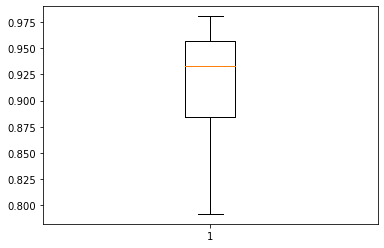

In [15]:
import matplotlib.pyplot as plt

plt.boxplot(auroc_list)
plt.show()

In [16]:
pd.DataFrame(auroc_list).to_csv("AUROC_list_CNN.csv", index=None)